# Generating input files necessary for the simulation
#### These files need to be generated for the main simulation. 

All you need to define is number of rows, columns, and if you want, number of time points T (min 3), average deme size N, and batch name - all your input files will use this batch name as prefix. 

### Demographic history

This file contains demographic history of the simulated population. It contains T rows (T different time points) of sub-populations sizes for each cell in the grid (rows x columns). Empty cells have sub-populations of size 0.
Function  generate_basic_homogenous_static(rows, cols, pop=10, time=3, batch_name='') generates T identical rows with population sizes N for the grid (rows x cols). It also makes a figure - map of the final time point (presence)
Saved into batch_name+'HomogFixedDataT'+str(T)+'Row'+str(rows)+'Col'+str(cols)+'N'+str(N)+'.txt'

Function generate_fixed_data(rows, cols, T, N,  batch_name=''): generates T identical rows with population sizes for the grid (rows x cols) drawn from uniform distribution with mean N (from 0 to 2N) and saves it into 
batch_name_dataT[T]Row[rows]Col[cols]N[N].txt'

### Migration list

Migration list with constant forward migration is generated, assuming that demes that share an edge are symmetrically connested with migration m. 
Migration list is saved to a file 'batch_name_mig_list[m].txt, as source cell, target cell, migration rate. By default migration rate is specified to 0.1. 

### Ancestral population list
This list contains information about the source population for each cell. Function generate_ancestral_pop(row, col, batch_name='') generates a vector of 1 (all sub-populations originating in a single population), saving it to 'batch_name_anc_pop.tsv'. 

### Sample list
Function generate_sample_list(rows, cols,s=0.1, batch_name='') randomly samples fraction s of all cells without repetition (2 samples are taken from each sampled grid cell by gridCoal simulator). Note that some of the sampled cells may be emptied at the final time point, resulting in an error. If no sample list is specified for gridCoal, it automatically samples all non-zero cells. 






In [65]:
import csv
import numpy as np
import timeit
from pathlib import Path
import random
import matplotlib.pyplot as plt
%matplotlib inline  

In [66]:
rows = 5   #number of rows
cols = 4   #number of columns
T = 10 #number of time steps
gt=2  #generation time
dt=20 # time between defined time steps
N=10  #average population size
mu=0.1 #migration rate between neighbouring demes
s = 0.5 # s is coverage - fraction of sampled grid cells. Note that using this function may include 
#some that are empty in the input data, which will cause error. Check before submitting for simulations. 

batch_name = 'example_simple_exp_'  #prefix used for input data associated with this simulation

In [67]:
def generate_final_map(rows, cols, N):
    ## this function can generate 3 types of final map, with individual deme sizes drawn from uniform 
    ## or Poisson distribution, or homogenous map with equal sized demes. It also plots the map. 
    
    #final_map=np.around(np.random.uniform(0,2*N,[rows*cols]))  #data drawn from uniform distribution
    final_map=np.around(np.random.poisson(N,[rows*cols]))      #data drawn from poisson distribution
    #final_map=[N]*(cols*rows)                                  #homogenous map
    final_map_2D=np.reshape(final_map, [rows, cols])
    plt.pcolor(final_map_2D)
    return (final_map)
    
def generate_lin_increase_data(final_map, T, batch_name=''):
    ## this function generates linear increase from size 1 to the final map over T time points
    demography_data=[]
    for i in range (T):
        this_timepoint=np.around((1.0+i)*final_map/T)
        demography_data.append(this_timepoint)
    demography_data=np.array(demography_data)
    np.savetxt(batch_name+'_lin_inc_N_'+str(N)+'.txt', my_demography,  fmt='%1d', delimiter='\t')

    return (demography_data.astype(int))  

def generate_static(final_map, T, batch_name=''):
    ## this function generates static demograhy for a final map over T time points
    demography_data=[]
    for i in range (T):
        this_timepoint=final_map.copy()
        demography_data.append(this_timepoint)
    demography_data=np.array(demography_data)
    np.savetxt(batch_name+'static_N_'+str(N)+'.txt', my_demography,  fmt='%1d', delimiter='\t')

    return (demography_data.astype(int))

def generate_migration_list(rows, cols, m=0.1, batch_name=''):
    n = rows*cols
    add_mat = np.zeros([n,n])
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: add_mat[i-1,i] = add_mat[i,i-1] = 1
            # Two outer diagonals
            if r > 0: add_mat[i-cols,i] = add_mat[i,i-cols] = 1
    m_list=[]
    for i in range(n):
        for j in range (n):
            if add_mat[i,j]==1:
                m_list.append([int(i),int(j),m])
    m_list=np.array(m_list) 
    np.savetxt(batch_name+'mig_list'+str(m)+'.txt', m_list, fmt= ['%i','%i','%4.2e'])
    return m_list
 
def generate_sample_list(rows, cols,s=0.5, batch_name=''):
    
    grid_size=rows*cols
    samples=int(grid_size*s)
    mr=range(0,grid_size,1)
    sample_list= (random.sample(range(0,grid_size,1), samples))
    sample_list.sort()
    np.savetxt(batch_name+'sample_list.txt',sample_list,  fmt='%1d', delimiter='\t')
    return sample_list

def generate_ancestral_pop(rows, cols, batch_name=''):
    ancestral_pop=[]
    for i in range(rows*cols):
        ancestral_pop.append(1)
    np.savetxt(batch_name+'anc_pop.txt', ancestral_pop, fmt= '%i')
    return ancestral_pop

def generate_ancestral_pop_sizes(test_data_T=1, batch_name=''):
    if type(test_data_T)==int:
        anc_pop_size=1
        f = open(batch_name+'anc_pop_size_1.tsv', 'w')
        
    else:
        last_datapoint=test_data_T[-1]  #make this changable
        anc_pop_size=sum(last_datapoint)
        f = open(batch_name+'anc_pop_size_sum.tsv', 'w')
    

    f.write(str(anc_pop_size))
    f.close()


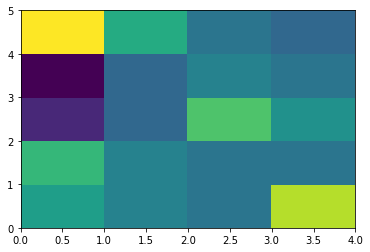

In [68]:
final_map = generate_final_map(rows, cols, N)   #generate final map
my_demography=generate_lin_increase_data(final_map, T, batch_name)  #generate linear increasing pop sizes leading to final map
mig_list= generate_migration_list(rows, cols, mu, batch_name)
sample_list=generate_sample_list(rows, cols,0.5, batch_name)
ancpop_list=generate_ancestral_pop(rows, cols, batch_name=batch_name )


In [69]:
print ('Final map', final_map)
print ('Demoggraphy', my_demography)
print ('Migration list', mig_list)
print ('Sampled cells', sample_list)
print ('Ancestral populations', ancpop_list)


Final map [12 10  9 18 14 10  9  9  4  8 15 11  2  8 10  9 20 13  9  8]
Demoggraphy [[ 1  1  1  2  1  1  1  1  0  1  2  1  0  1  1  1  2  1  1  1]
 [ 2  2  2  4  3  2  2  2  1  2  3  2  0  2  2  2  4  3  2  2]
 [ 4  3  3  5  4  3  3  3  1  2  4  3  1  2  3  3  6  4  3  2]
 [ 5  4  4  7  6  4  4  4  2  3  6  4  1  3  4  4  8  5  4  3]
 [ 6  5  4  9  7  5  4  4  2  4  8  6  1  4  5  4 10  6  4  4]
 [ 7  6  5 11  8  6  5  5  2  5  9  7  1  5  6  5 12  8  5  5]
 [ 8  7  6 13 10  7  6  6  3  6 10  8  1  6  7  6 14  9  6  6]
 [10  8  7 14 11  8  7  7  3  6 12  9  2  6  8  7 16 10  7  6]
 [11  9  8 16 13  9  8  8  4  7 14 10  2  7  9  8 18 12  8  7]
 [12 10  9 18 14 10  9  9  4  8 15 11  2  8 10  9 20 13  9  8]]
Migration list [[ 0.   1.   0.1]
 [ 0.   4.   0.1]
 [ 1.   0.   0.1]
 [ 1.   2.   0.1]
 [ 1.   5.   0.1]
 [ 2.   1.   0.1]
 [ 2.   3.   0.1]
 [ 2.   6.   0.1]
 [ 3.   2.   0.1]
 [ 3.   7.   0.1]
 [ 4.   0.   0.1]
 [ 4.   5.   0.1]
 [ 4.   8.   0.1]
 [ 5.   1.   0.1]
 [ 5.   4.   0.1]
